## Procesado previo

In [3]:
import utils
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
df_list = utils.read_data('train')
train_sub, val_sub = train_test_split(np.arange(1, 31), train_size = 0.8, random_state = 42)

In [5]:
def data_range(x):
  return x.max()-x.min()

def rms(x):
  z = x*x
  sum = z.sum()
  result = np.sqrt(sum/len(x))

  return result

# Zero crossing rate
def zcr(x):
  x = np.array(x)
  n = len(x)
  zc = ((x[:-1] * x[1:]) < 0).sum()
  return zc/n

def mcr(x):
  x = np.array(x)
  z = x-np.mean(x)
  return zcr(z)

#waveform length
def wl(data):
    return np.sum(np.abs(np.diff(data,axis=0)), axis=0)

features = [wl, 'mad', mcr, rms, data_range, 'kurtosis']

In [6]:
# Sustraer promedio
channels = [f'channel{i}' for i in range(1,9)]
df_list1 = [utils.substract_mean(x, channels) for x in df_list]

# Quitar canal 3
df_list1 = [x.drop(['channel3'], axis=1) for x in df_list1]

## Simplificación de entrenamiento

In [7]:
def train_with_wrapper(df_list, train_sub, val_sub, features, grid_dict):
  wrapper = utils.TrainWrapper(df_list)
  wrapper.split(train_sub, val_sub) # Split train/val
  wrapper.make_windows() # Crear ventanas
  wrapper.compute_features(features)
  wrapper.make_test_folds() # Crear x_tv, y_tv y cv

  for key in grid_dict:
    grid_dict[key].cv = wrapper.cv # Setea cross-validation fold
  
  wrapper_trained = utils.multitrain(grid_dict, wrapper.x_tv, wrapper.y_tv)

  return wrapper_trained, wrapper

### Grids

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [9]:
param_grids = {
    'linear' : [{
        'C':[0.001, 0.1, 1, 10],
        'kernel': ['linear']
        }],

     'poly' : [{
          'C': [1e-2, 1e-1, 1],
          'gamma':[1e-1, 1, 1e1],
          'degree':[2, 3],
          'kernel': ['poly']
                  }],
    'rbf': [{
          'C': [0.01, 0.1, 1.0, 10.0],
          'gamma': [1e-1, 1, 10],
          'kernel': ['rbf']
                  }],
    'knn': [{
        'n_neighbors':[5, 10, 15, 20],
        'algorithm': ['ball_tree', 'kd_tree']}],  

    'boost': [{
        'n_estimators': np.arange(10, 111, 20)}],

    'forest': [{
          'n_estimators': np.arange(150, 351, 100),
          'criterion' : ['entropy']
                        }]
}


In [10]:
param_grids.keys()

dict_keys(['linear', 'poly', 'rbf', 'knn', 'boost', 'forest'])

In [31]:
estimators = {
    'linear': SVC(), 'poly': SVC(), 'rbf': SVC(),
     'knn': KNeighborsClassifier(), 'boost': AdaBoostClassifier(),
      'forest': RandomForestClassifier()
}

## Entrenamiento

In [32]:
wrapper = utils.TrainWrapper(df_list1)
wrapper.split(train_sub, val_sub) # Split train/val
wrapper.make_windows(step = 150) # Crear ventanas
wrapper.compute_features(features)
wrapper.make_test_folds() # Crear x_tv, y_tv y cv

In [33]:
common = {'scoring':'balanced_accuracy', 'refit':True, 'verbose':1}

In [34]:
pre_estimators = ['linear', 'boost', 'forest']
pre_grid = {}
for p in pre_estimators:
  pre_grid[p] = GridSearchCV(estimator = estimators[p], param_grid = param_grids[p],
                             cv = wrapper.cv, **common)

In [35]:
wrapper_trained = utils.multitrain(pre_grid, wrapper.x_tv, wrapper.y_tv)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
Fitting 1 folds for each of 6 candidates, totalling 6 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [36]:
wrapper_trained

{'boost': [AdaBoostClassifier(n_estimators=10), {'n_estimators': 10}],
 'forest': [RandomForestClassifier(criterion='entropy', n_estimators=250),
  {'criterion': 'entropy', 'n_estimators': 250}],
 'linear': [SVC(C=0.1, kernel='linear'), {'C': 0.1, 'kernel': 'linear'}]}

In [37]:
import sklearn.metrics as metrics

In [38]:
pre_accs = {}

for x in wrapper_trained:
    cl = wrapper_trained[x][0]
    pre_predictv = cl.predict(wrapper.x_val)
    pre_predict = cl.predict(wrapper.x_train)

    pre_accs[x] = (metrics.accuracy_score(wrapper.y_train, pre_predict),
                    metrics.accuracy_score(wrapper.y_val, pre_predictv))

In [39]:
pre_accs

{'boost': (0.3271397509389207, 0.3344327176781003),
 'forest': (1.0, 1.0),
 'linear': (0.868155762008302, 0.9518469656992085)}

In [40]:
from sklearn.feature_selection import SelectFromModel

In [41]:
selector = SelectFromModel(wrapper_trained['forest'][0]).fit(wrapper.x_train, wrapper.y_train)
x_trainr = selector.transform(wrapper.x_train)
x_valr = selector.transform(wrapper.x_val)
x_tvr = np.concatenate([x_trainr, x_valr])

In [42]:
print(f'{wrapper.x_train.shape[-1]}, {x_tvr.shape[-1]}')

42, 18


In [43]:
grid = {}
for p in estimators.keys():
    grid[p] = GridSearchCV(estimator = estimators[p], param_grid = param_grids[p],
                             cv = wrapper.cv, **common)

In [44]:
trained = utils.multitrain(grid, x_tvr, wrapper.y_tv)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
Fitting 1 folds for each of 18 candidates, totalling 18 fits
Fitting 1 folds for each of 12 candidates, totalling 12 fits
Fitting 1 folds for each of 8 candidates, totalling 8 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [106]:
print('Hiper-parámetros')
for key in trained:
  print(f'{key}: {trained[key][0]}')

Hiper-parámetros
linear: SVC(C=10, kernel='linear')
poly: SVC(C=0.1, degree=2, gamma=10.0, kernel='poly')
rbf: SVC(C=0.1, gamma=1)
knn: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=20)
boost: AdaBoostClassifier(n_estimators=30)
forest: RandomForestClassifier(criterion='entropy', n_estimators=350)


In [45]:
accs = {}

for x in trained:
    cl = trained[x][0]
    predictv = cl.predict(x_valr)
    predict = cl.predict(x_trainr)

    accs[x] = (metrics.accuracy_score(wrapper.y_train, predict),
                    metrics.accuracy_score(wrapper.y_val, predictv))

In [137]:
frac = len(wrapper.x_val)/(len(wrapper.x_train)+ len(wrapper.x_val))
frac

0.2305703422053232

In [167]:
ann = MLPClassifier((30, 30, 30), shuffle = False, random_state = 42, early_stopping=True,
              validation_fraction = frac, learning_rate='adaptive')

In [168]:
ann.fit(x_tvr, wrapper.y_tv)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', random_state=42, shuffle=False,
              validation_fraction=0.2305703422053232)

In [ ]:
for i in range(1,7):
  print(f'label={i}')
  print((np.array(wrapper.y_train) == i).sum())
  print((np.array(wrapper.y_val) == i).sum())

In [169]:
predictv = ann.predict(x_valr)
predict = ann.predict(x_trainr)

accs['ann'] = (metrics.accuracy_score(wrapper.y_train, predict),
                    metrics.accuracy_score(wrapper.y_val, predictv))

In [170]:
accs

{'ann': (0.9134216248270409, 0.9650395778364116),
 'boost': (0.34275548527376953, 0.3891820580474934),
 'forest': (1.0, 1.0),
 'knn': (0.9325953745799566, 0.962401055408971),
 'linear': (0.8464123344534493, 0.9610817941952506),
 'poly': (0.8857481715754102, 0.9472295514511874),
 'rbf': (0.8331686103973117, 0.9320580474934037)}

## Matrices de confusión

Accuracy = 1.0


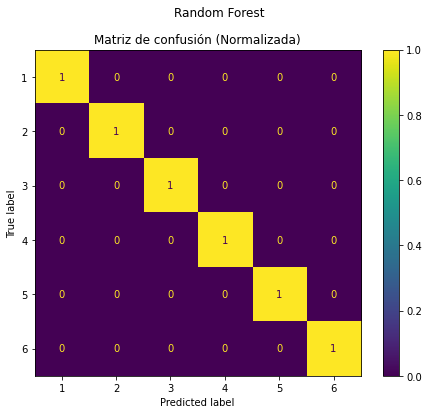

In [101]:
c = utils.show_matrixes(wrapper.y_val, trained['forest'][0].predict(x_valr), 'Random Forest')

Accuracy = 0.962


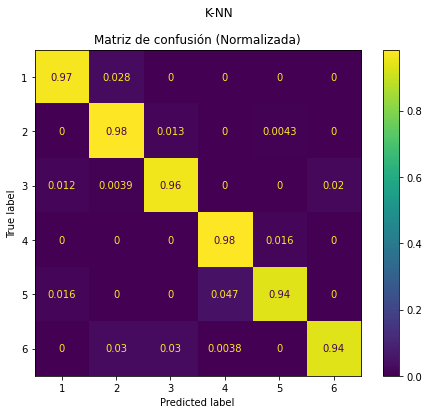

In [148]:
c =  utils.show_matrixes(wrapper.y_val, trained['knn'][0].predict(x_valr), 'K-NN')

Accuracy = 0.965


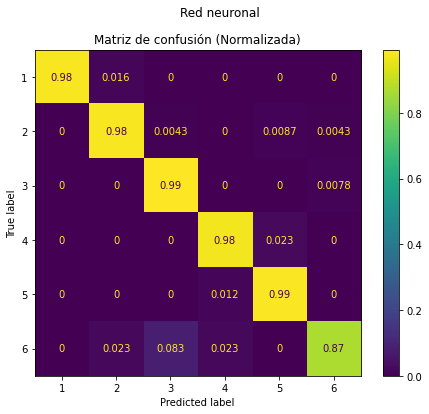

In [172]:
c = utils.show_matrixes(wrapper.y_val, ann.predict(x_valr), 'Red neuronal')

## Predicción para conjunto de prueba

In [138]:
path_test = 'windows_test.csv'
test_data = utils.read_test_data(path_test)

In [139]:
test_list = [pd.DataFrame(np.delete(test_data[i], 2, axis=1)) for i in range(len(test_data))] # Sin canal 3

In [142]:
x_test = utils.window_to_features(test_list, features)

In [143]:
x_tests = wrapper.scaler.transform(x_test)
x_testr = selector.transform(x_tests)

In [144]:
x_testr.shape

(672, 18)

In [164]:
#y_predict = trained['forest'][0].predict(x_testr)
#y_predict = trained['knn'][0].predict(x_testr)
y_predict = ann.predict(x_testr)

In [178]:
y_predict

array([6, 3, 2, 4, 3, 4, 3, 4, 6, 2, 3, 1, 4, 5, 3, 1, 4, 5, 3, 6, 4, 5,
       1, 5, 5, 2, 6, 1, 6, 2, 5, 5, 6, 3, 6, 6, 6, 2, 3, 2, 5, 5, 6, 5,
       1, 5, 4, 2, 3, 3, 1, 2, 1, 6, 5, 1, 3, 3, 6, 2, 4, 4, 2, 5, 4, 5,
       2, 6, 2, 4, 1, 5, 2, 5, 5, 2, 2, 2, 6, 6, 1, 4, 3, 6, 4, 5, 4, 4,
       6, 1, 3, 4, 4, 2, 4, 1, 5, 3, 2, 1, 4, 1, 4, 2, 5, 1, 5, 4, 1, 5,
       5, 3, 6, 5, 2, 6, 4, 2, 5, 3, 3, 2, 6, 1, 2, 4, 5, 5, 2, 4, 1, 5,
       4, 4, 2, 2, 1, 2, 4, 3, 5, 6, 2, 5, 2, 6, 4, 4, 6, 2, 3, 2, 1, 6,
       1, 3, 3, 5, 6, 2, 1, 3, 6, 1, 5, 1, 3, 5, 6, 2, 6, 4, 2, 5, 2, 5,
       2, 5, 1, 6, 1, 1, 5, 3, 5, 4, 3, 2, 6, 4, 2, 1, 6, 5, 6, 4, 6, 6,
       3, 2, 1, 1, 6, 6, 4, 6, 3, 4, 4, 5, 5, 2, 6, 1, 3, 4, 6, 2, 1, 5,
       5, 2, 6, 1, 6, 1, 2, 1, 6, 3, 2, 1, 1, 3, 6, 6, 5, 6, 6, 6, 5, 5,
       5, 4, 4, 6, 6, 6, 6, 1, 2, 4, 3, 6, 4, 2, 6, 6, 1, 4, 6, 3, 3, 4,
       6, 5, 6, 5, 2, 4, 4, 4, 3, 2, 5, 1, 4, 4, 5, 1, 5, 4, 6, 2, 1, 3,
       5, 4, 3, 6, 2, 4, 4, 2, 1, 6, 5, 1, 3, 3, 6,

In [154]:
y_kaggle = pd.DataFrame(np.arange(0, 672), columns=['Id'])
y_kaggle['Category'] = y_predict
y_kaggle.to_csv('predict.csv', index=False)